<a href="https://colab.research.google.com/github/karlgelbjerg/Economic-modelling-final-group-/blob/main/Final_group_project_Economic_modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

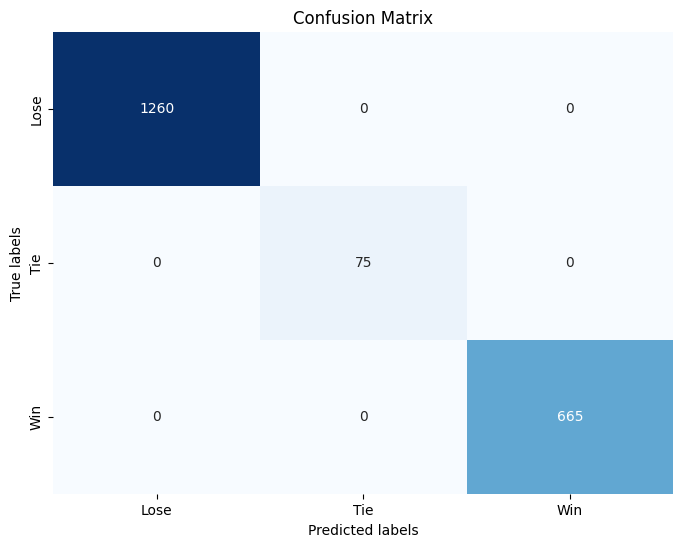

*Confusion Matrix:*
[[1260    0    0]
 [   0   75    0]
 [   0    0  665]]

*Accuracy:* 1.00

*Precision:* 1.00

*Recall:* 1.00

*F1 Score:* 1.00

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

# function that draw the cards
def draw_card():
    card = np.random.choice(['2', '3', '4', '5', '6', '7', '8', '9', '10', 'J', 'Q', 'K', 'A'])
    if card in ['J', 'Q', 'K']:
        return 10
    elif card == 'A':
        return 11
    else:
        return int(card)

# function to calculate the best hand
def hand_value(hand):
    value = sum(hand)
    num_aces = hand.count(11)
    while value > 21 and num_aces:
        value -= 10
        num_aces -= 1
    return value

# blackjack dataset
def simulate_blackjack_games(num_games=10000):
    data = []
    for _ in range(num_games):
        player_hand = [draw_card(), draw_card()]
        dealer_hand = [draw_card(), draw_card()]

        player_value = hand_value(player_hand)
        dealer_value = hand_value(dealer_hand)

        if player_value == 21:
            result = 'win' if dealer_value != 21 else 'tie'
        elif dealer_value == 21:
            result = 'lose'
        else:
            while player_value < 21 and np.random.rand() > 0.5:
                player_hand.append(draw_card())
                player_value = hand_value(player_hand)

            while dealer_value < 17:
                dealer_hand.append(draw_card())
                dealer_value = hand_value(dealer_hand)

            if player_value > 21:
                result = 'lose'
            elif dealer_value > 21 or player_value > dealer_value:
                result = 'win'
            elif player_value < dealer_value:
                result = 'lose'
            else:
                result = 'tie'

        data.append({
            'player_value': player_value,
            'dealer_value': dealer_value,
            'player_card_count': len(player_hand),
            'result': result
        })

    return pd.DataFrame(data)

# generate the database
blackjack_data = simulate_blackjack_games(10000)
blackjack_data['result'] = blackjack_data['result'].map({'win': 1, 'lose': -1, 'tie': 0})

X = blackjack_data[['player_value', 'dealer_value', 'player_card_count']]
y = blackjack_data['result']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)   #test_size = 20% so confusion matrix reflects the predictions made on the test size, 2,000 games.

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

calibrated_rf = CalibratedClassifierCV(estimator=rf_model, method='isotonic', cv='prefit')
calibrated_rf.fit(X_test, y_test)

y_pred = calibrated_rf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# this is the function to print the confusion matrix, we add markdown, which is a function that improves the design display of the results when printed
def display_evaluation_metrics(cm, accuracy, precision, recall, f1):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=['Lose', 'Tie', 'Win'], yticklabels=['Lose', 'Tie', 'Win'])
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()
    display(Markdown(f"*Confusion Matrix:*\n{cm}"))       #gives a detailed breakdown of correct and incorrect predictions for each issue in the blackjack.
    display(Markdown(f"*Accuracy:* {accuracy:.2f}"))      #gives the overall correctness of the model's predictions
    display(Markdown(f"*Precision:* {precision:.2f}"))    #gives the percentage of correct positive predictions out of all positive predictions made by the model (how many wins predicted by the model compared to how many wins really hapenned)
    display(Markdown(f"*Recall:* {recall:.2f}"))          #gives the  ratio of true positive predictions to the total number of actual positive instances ( how many wins predicted by the model compared to the amout of win in the game)
    display(Markdown(f"*F1 Score:* {f1:.2f}"))            # mean of precision and recall (2 * (Precision * Recall) / (Precision + Recall)) that gives a balanced result of the two.

# print the metrics
display_evaluation_metrics(cm, accuracy, precision, recall, f1)



#confusion matrix : x games predicted as losses are actual losses. x games predicted as ties are actual ties. x games predicted as wins are actual wins.
#Accuracy : model correctly predicts the outcome of every game
#Precision : the model predicts an outcome (win, lose, or tie)
#Recall : model detected all actual outcomes without missing one
#F1 Score : model achieves a perfect balance between precision and recall